# Project: Retail Returns Prediction



## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#clean">Data Cleaning & Preprocessing</a></li>
<li><a href="#model">Modelling</a></li>
<li><a href="#test">Testing Phase</a></li>
</ul>



<a id='intro'></a>
## Introduction

In this assesment, We've been given a task to predict wheter a customer will return a purchased item or not. We have been given a dataset of a online retailer with some features to predict the outcome. The goal is to show warning message at the time of purchase to identify if the items has chances to be returned to reduce retailer's cost budget. There are 2 datasets, one training and one for testing. We will be trainig our model on the training set comprising of 100000 rows and also doing some validations on the same set using some splits.The final output of test set is to be stored in the csv

<a id='clean'></a>

## Data Cleaning & Preprocessing

#### Pre-requisites

Lets first import all the packages beforehand at one place that we will be using in this project.

In [38]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime,date
from time import strptime
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


#### Data Inspection

Here we will just read the data and see the overview of how it looks like and what type of data are we dealing with

In [39]:
#Reading the dataset
df=pd.read_csv("training_set.csv")

#finding total rows and columns
print ("Columns in the dataset: ", df.shape[1])
print ("Rows in the dataset   : ", df.shape[0])


df.head()

Columns in the dataset:  14
Rows in the dataset   :  100000


,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
1,2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
3,4,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
4,5,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1


First thingto check is what kind of problem we are dealing with, What is our output variable, how many classes does it have and what is the ratio of classes

In [40]:
df['return'].value_counts()

0    54182
1    45818
Name: return, dtype: int64

#### Null Values
First need we need to check is if our data has any null/nan values, as they are destructive and cause model fitting problems.So, its best to find them early and then plan a suitable strategy to remove/mitigate/substitute them. We can easily see them using the info function of pandas along with their datatypes.

In [41]:
#Checking datatypes and non-null values of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_item_id  100000 non-null  int64  
 1   order_date     100000 non-null  object 
 2   delivery_date  90682 non-null   object 
 3   item_id        100000 non-null  int64  
 4   item_size      100000 non-null  object 
 5   item_color     100000 non-null  object 
 6   brand_id       100000 non-null  int64  
 7   item_price     100000 non-null  float64
 8   user_id        100000 non-null  int64  
 9   user_title     100000 non-null  object 
 10  user_dob       91275 non-null   object 
 11  user_state     100000 non-null  object 
 12  user_reg_date  100000 non-null  object 
 13  return         100000 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 10.7+ MB


As we know we have 100000 rows so most of the columns have almost all values as non-null but some look like nulls, for better understanding we can look null values of each column.

In [42]:
#further checking the count of null values in each column
df.isna().sum()

order_item_id       0
order_date          0
delivery_date    9318
item_id             0
item_size           0
item_color          0
brand_id            0
item_price          0
user_id             0
user_title          0
user_dob         8725
user_state          0
user_reg_date       0
return              0
dtype: int64

We can see that delivery_date and user_dob have a lot of nulls, we can find % of null values of each column from code below. And we can see that 8-10% of values in these columns are null.If we remove rows then we would be at best case scenario losing 10% of data and if these values of 2 columns are not overlapping then we could lose around 18% of data, So its not recommended here that we drop these rows. Next we can do is drop columns entirely, Now since we already have not many features and these columns do look important for our target feature we can't do that either. Our last option is to replace these values with mean/median of their columns but since we can't use dates like these we have to do some feature engineering and make suitable attributes.

#### Feature Engineering
In this section we will make useful features out of the features that are given to us, First set of feature is user_dob, we don't have much use of this feature but we can calculate age which can be useful. Also we can also replace null/missing values with mean/median of age column for each class as both classes can have different median/means.

In [43]:
#function to convert date to speicif format
def __datetime(date_str):
    
    #for null values set dob as current date to identify them as their age will be 0
    if date_str!=date_str:
        date_str=str(date.today())

    return datetime.strptime(date_str, '%Y-%m-%d')

#subtracting dob with current date and converting to years.
df['Age']=(__datetime(str(date.today()))-df.user_dob.apply(__datetime))/365
df['Age']=df.Age.apply(lambda x: int(str(x).split(" ")[0]) )

In [44]:

#function to impute 0 values
def imputing_age(x,y):
    x0=x[x['return']==1] # subset comprising of return
    x1=x[x['return']==0] # subset comprising of non-return
    x0[y] =x0[y].map( lambda x : x0[y].median() if x == 0 else x) #replacing returns 0s with returns median
    x1[y] =x1[y].map( lambda x : x1[y].median() if x == 0 else x) #replacing non-returns 0s with non-returns median
    return pd.concat([x0,x1])

#Imputing 0 values with median for each class
df=imputing_age(df,'Age')


C:\Users\wahab.aftab\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\wahab.aftab\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now that we have age we have no use of user_dob column, so we can drop that and see if Age column has any nulls.

In [45]:
df.drop(['user_dob'], axis=1,inplace=True)
df.isna().sum()

order_item_id       0
order_date          0
delivery_date    9318
item_id             0
item_size           0
item_color          0
brand_id            0
item_price          0
user_id             0
user_title          0
user_state          0
user_reg_date       0
return              0
Age                 0
dtype: int64

We can see that we have extracted a useful feature age from user_dob and that too without null values. Now we have do similar thing to delivery date as its not useful alone but can be made useful. First thing we can do is find delivery time which is delivery_date-order_date and we can also find useful features like what is month of delivery as during holidays can have different trends and what is the day of delivery, people prefer deliveries on weekends etc.

In [46]:
#function to convert date to specific format and to handle null dates
def datetime_delivery(date_str):
    #if date is null set it to 1900-01-01 to identify it and so that difference will be less than 0
    if date_str!=date_str:
        date_str='1900-01-01'

    return datetime.strptime(date_str, '%Y-%m-%d')

def weekday(x):
    #setting null date value to noday for weekday
    if x!=x:
        x='NoDay'
    else:
        x=datetime.strptime(x, '%Y-%m-%d').strftime('%A')
    return x
def month(x):
    #setting null date value to nomonth for month
    if x!=x:
        x='NoMonth'
    else:
        x=datetime.strptime(x, '%Y-%m-%d').strftime('%B')
    return x


#finding differece of order and delivery date
df['Delivery_time']=(df.delivery_date.apply(datetime_delivery)-df.order_date.apply(datetime_delivery))
df['Delivery_time']=df.Delivery_time.apply(lambda x: int(str(x).split(" ")[0]) )
#finding weekday
df['Weekday']=df.delivery_date.apply(weekday)
#finding month
df['Month']=df.delivery_date.apply(month)

For null values in these 3 columns we have to do different things, for delivery_Time method is the same as age. So, lets do that first, as we have identified in above function that delivery_time less 0 will be for null values, we can simply replace them.

In [47]:
def imputing_delivery(x,y):
    x0=x[x['return']==1] # subset comprising of return
    x1=x[x['return']==0] # subset comprising of non-return
    x0[y] =x0[y].map( lambda x : x0[y].median() if x <= 0 else x) #replacing returns  delivery time less than 0 with returns median
    x1[y] =x1[y].map( lambda x : x1[y].median() if x <= 0 else x) #replacing non-returns delivery time less than 0 with non-returns median
    return pd.concat([x0,x1])
#Imputing 0 values with median for each class
df=imputing_delivery(df,'Delivery_time')

C:\Users\wahab.aftab\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\wahab.aftab\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Now lets find most count of weekday for when user return values and also for non-return values

In [48]:
df['Weekday'][df['return']==0].value_counts(),df['Weekday'][df['return']==1].value_counts()


(Sunday       11292
 Monday        9443
 Saturday      9368
 NoDay         9318
 Tuesday       7744
 Wednesday     6821
 Thursday       196
 Name: Weekday, dtype: int64,
 Sunday       11736
 Monday        9636
 Saturday      9375
 Tuesday       7763
 Wednesday     7108
 Thursday       200
 Name: Weekday, dtype: int64)

We can see that both classes have sunday with most counts so we can take sunday to replace NoDay computed above.

In [49]:
#replacing NoDay with Sunday in weekday column

df['Weekday']=df['Weekday'].apply(lambda x: x if x!='NoDay' else 'Sunday')
#Now we have replaced all NoDays with sundays
df['Weekday'].value_counts()

Sunday       32346
Monday       19079
Saturday     18743
Tuesday      15507
Wednesday    13929
Thursday       396
Name: Weekday, dtype: int64

In [50]:
df['Month'][df['return']==0].value_counts(),df['Month'][df['return']==1].value_counts()


(August       17843
 July         14648
 NoMonth       9318
 September     6538
 June          3630
 October       1018
 December       718
 November       468
 January          1
 Name: Month, dtype: int64,
 August       19001
 July         13844
 September     6819
 June          4123
 October       1035
 November       559
 December       435
 January          2
 Name: Month, dtype: int64)

After doing similar stuff for month we can see below as August is the most busy month for both classes so simply replacing NoMonth by August will be good.

In [51]:
#replacing NoMonth with August in month column
df['Month']=df['Month'].apply(lambda x: x if x!='NoMonth' else 'August')
#Now we have replaced all NoMonth with August
df['Month'].value_counts()

August       46162
July         28492
September    13357
June          7753
October       2053
December      1153
November      1027
January          3
Name: Month, dtype: int64

we have to convert user_reg_date to a useful feature as well.It can tell us how long a user has been with the retailer so we can find age with retailer in days.

In [52]:
#converting to suitable date format
def __datetime_reg(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

#subtracting registration date by current date to find days with retailer
df['user_Age']=(__datetime_reg(str(date.today()))-df.user_reg_date.apply(__datetime_reg))
df['user_Age']=df.user_Age.apply(lambda x: int(str(x).split(" ")[0]) )
df['user_Age'].value_counts()

2254    33966
1757     1325
1755     1064
1756      951
1754      821
        ...  
2087        4
1943        3
2095        2
1944        1
2101        1
Name: user_Age, Length: 573, dtype: int64

Registraiton age is also extracted, Now ss we have fully used delivery_date,user_reg_date and order_date we don't need them anymore and we can simply drop them. Also as we have removed all null values our data is free of nulls and we can move to next step.

In [53]:
df.drop(['order_date','delivery_date','user_reg_date'], axis=1,inplace=True)
df.isna().sum()

order_item_id    0
item_id          0
item_size        0
item_color       0
brand_id         0
item_price       0
user_id          0
user_title       0
user_state       0
return           0
Age              0
Delivery_time    0
Weekday          0
Month            0
user_Age         0
dtype: int64

#### Categorical Features
Now lets see the how many of our features are categorical. This is important because we can only use numerical data for modelling but categoricald data holds importance So we have to convert any categorical data to numerical by using techniques like One-Hot Encode or Label Encoing.

In [54]:
#getting total columns
cols=df.columns
print("Total Columns in dataset are: ",list(cols))

#getting only numerical columns
numerical_cols=df._get_numeric_data().columns
print("Numerical Columns in dataset are: ",list(numerical_cols))

#getting categorical columns by substracting numerical columns from total columns
categorical_cols=set(list(cols))-set(list(numerical_cols))
print("Categorical Columns in dataset are: ",list(categorical_cols))



Total Columns in dataset are:  ['order_item_id', 'item_id', 'item_size', 'item_color', 'brand_id', 'item_price', 'user_id', 'user_title', 'user_state', 'return', 'Age', 'Delivery_time', 'Weekday', 'Month', 'user_Age']
Numerical Columns in dataset are:  ['order_item_id', 'item_id', 'brand_id', 'item_price', 'user_id', 'return', 'Age', 'Delivery_time', 'user_Age']
Categorical Columns in dataset are:  ['Month', 'Weekday', 'item_size', 'item_color', 'user_title', 'user_state']


There are many categorical columns in the dataset and as model can take numerical inputs, SO we should handle these carefully. Using the context and common knowledge we can say that item_color and user_state aren't generally a factor if a person returns an item or not So we can remove them later if needed. User_title can be important as it has some information about gender of the individual.So, lets handle that

In [55]:
le = preprocessing.LabelEncoder()
print ("Before Encoding: ",df['user_title'].unique())

#encoding user_title to numerical values
df['user_title'] = le.fit_transform(df.user_title.values)

print ("After Encoding:  ",df['user_title'].unique())


Before Encoding:  ['Mrs' 'Family' 'Mr' 'Company' 'not reported']
After Encoding:   [3 1 2 0 4]


As you can see we have converted each string from user_title to a number that a model can understand using encoding, We could have used one-hot encoding but it would have increased feature space So label encoding is good for this. For month and weekday, we already know encoding for this and since as seen before dataset doesn't have all months and weekdays So its better to define own encoding as we might see those months/weekdays later in test or unseen data.

In [56]:
def month_encode(x):
    return strptime(x,'%B').tm_mon

df['Month']=df.Month.apply(month_encode)
df['Month'].value_counts()

8     46162
7     28492
9     13357
6      7753
10     2053
12     1153
11     1027
1         3
Name: Month, dtype: int64

We can see that we have converted all month values to numerical ones, Lets do that same for weekday.

In [57]:
def weekday_encode(x):
    return strptime(x,'%A').tm_wday
df['Weekday']=df.Weekday.apply(weekday_encode)
df['Weekday'].value_counts()

6    32346
0    19079
5    18743
1    15507
2    13929
3      396
Name: Weekday, dtype: int64

Item_size is a tricky variable as its a mixture of both numerical and categorical values. Lets take a look.

In [58]:
df['item_size'].value_counts()

l       12347
xl      10979
m       10190
xxl      8966
40       7693
        ...  
49          1
12+         1
105         1
4034        1
84          1
Name: item_size, Length: 102, dtype: int64

As we can see that item sizes are given in numerical as well as xl,xxl,s,m denoting different sizes. Now we do know what they mean but we have no mapping for them to convert them to numbers. What we can do is see quantile of numerical values and assign these sizes those appropriate quanitles.

In [59]:
def item_map(x):
    #removing + sign from sizes
    x=x.replace("+","")
    
    #if size is categorical replace it with nan
    if x.isnumeric()==False:  
        x=np.nan
    return float(x)
df['item_size_numerical']=df.item_size.apply(item_map)
df.item_size_numerical.quantile([0.02,0.08,.12, .3,.6, .8,0.98])

0.02     6.0
0.08    10.0
0.12    29.0
0.30    38.0
0.60    40.0
0.80    42.0
0.98    48.0
Name: item_size_numerical, dtype: float64

As we have 6 quantiles and we know how xl,l,s  relate to each other we can assign each category to a quanatile

In [60]:
def item_map_category(x):
    x=x.replace("+","")
    if x.isnumeric()==False:  
        if x=='xxxl':
            x=48
        elif x=='xxl':
            x=42
        elif x=='xl':
            x=40
        elif x=='l':
            x=38
        elif x=='m':
            x=29
        elif x=='s':
            x=10
        elif x=='xs':
            x=6
        else: #for non-reported size we choosing mid value
            x=40
    return int(x)
df['item_size_fixed']=df.item_size.apply(item_map_category)
df.item_size_fixed.value_counts()

40      24082
38      18118
42      14058
29      10337
39       6747
        ...  
105         1
3634        1
84          1
3834        1
3132        1
Name: item_size_fixed, Length: 72, dtype: int64

We can remove state and color as they don't look promising features, Also we have to remove features created to achieve final resutls also redundant features like order ID.

In [61]:
df.drop(['item_color','user_state','item_size','item_size_numerical','order_item_id','user_id'], axis=1,inplace=True)

Rerunning above code we can see that none of the categorical features are left now we can move towards modelling.

In [62]:
#getting total columns
cols=df.columns
print("Total Columns in dataset are: ",list(cols))

#getting only numerical columns
numerical_cols=df._get_numeric_data().columns
print("Numerical Columns in dataset are: ",list(numerical_cols))

#getting categorical columns by substracting numerical columns from total columns
categorical_cols=set(list(cols))-set(list(numerical_cols))
print("Categorical Columns in dataset are: ",list(categorical_cols))



Total Columns in dataset are:  ['item_id', 'brand_id', 'item_price', 'user_title', 'return', 'Age', 'Delivery_time', 'Weekday', 'Month', 'user_Age', 'item_size_fixed']
Numerical Columns in dataset are:  ['item_id', 'brand_id', 'item_price', 'user_title', 'return', 'Age', 'Delivery_time', 'Weekday', 'Month', 'user_Age', 'item_size_fixed']
Categorical Columns in dataset are:  []


In [63]:
df.head()

,item_id,brand_id,item_price,user_title,return,Age,Delivery_time,Weekday,Month,user_Age,item_size_fixed
2,270,49,79.9,3,1,51.0,5.0,0,6,2228,42
4,561,3,14.9,3,1,51.0,5.0,0,6,2228,42
5,579,3,19.9,3,1,51.0,5.0,0,6,2228,42
7,106,6,39.9,3,1,51.0,5.0,0,6,2228,50
8,195,46,13.9,3,1,51.0,5.0,0,6,2228,42


## Pre modelling

Before we move towards modelling we have to see if some features are identitical hence redundant or if some features have abnormal or outliers. For dependence of features we can create correlation matrix to see if they correlate with each other.

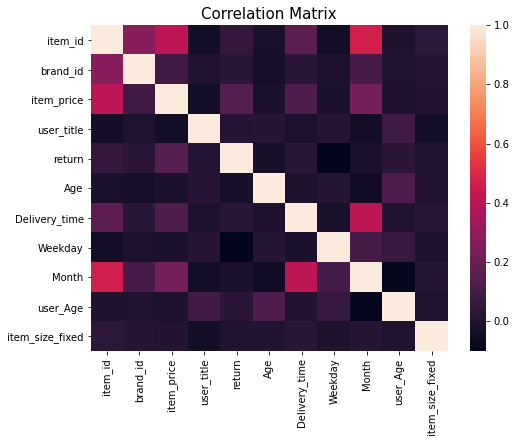

In [76]:
#Correlation Matrix
plt.figure(figsize=(8,6))
corr=df.corr()
plt.title("Correlation Matrix",fontsize="15")
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

We can see that none of the features are entiery depended on other features but rather different in their own way. We can also see that item_price has the lighest color with target feature meaning its one of the most important feature as expected.For outliers, we can see data distribution 

In [65]:
df.describe()

,item_id,brand_id,item_price,user_title,return,Age,Delivery_time,Weekday,Month,user_Age,item_size_fixed
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,923.781820,30.149020,65.064695,2.949870,0.458180,56.409520,6.852900,3.323440,7.811370,1998.913230,39.763690
std,702.568822,28.180191,47.991546,0.256627,0.498251,10.838939,12.873349,2.456214,1.026421,224.261795,108.223715
min,1.000000,1.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,1.000000,1681.000000,1.000000
25%,214.000000,5.000000,29.900000,3.000000,0.000000,51.000000,2.000000,1.000000,7.000000,1760.000000,38.000000
50%,812.000000,25.000000,49.900000,3.000000,0.000000,55.000000,3.000000,5.000000,8.000000,1990.000000,40.000000
75%,1581.000000,44.000000,79.900000,3.000000,1.000000,61.000000,4.000000,6.000000,8.000000,2254.000000,41.000000
max,2241.000000,138.000000,999.000000,4.000000,1.000000,120.000000,173.000000,6.000000,12.000000,2254.000000,4034.000000


As there are some outliers but most of the values are consistent, we can remove that if we want. But we can make models which are robust to outliers.

<a id='model'></a>

## Modelling
In this phase we will be using different algorithms and different approaches to predict returns

#### Data Preparation 

In this section we are splitting our data to train and test set, with our test set 15% of the original data. Then we are normalizing all features to 0-1 values so that our model runs fast 

In [66]:
x = df.drop(['return'],axis=1) #training features
y = df['return'] # target variable
X_train, X_test1, y_train, y_test= train_test_split(x, y, test_size=0.15, random_state=42)

#converting to numpy array
X_train= np.array(X_train)
y_train = np.array(y_train)
X_test1 = np.array(X_test1)
y_test = np.array(y_test)


In [67]:
#normalizing features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test1)


#### Training Model

Next step is to decide a model,  I tested the data on multiple models like decision trees, xgboost, logistic regression, SVM, Random Forest etc. Out of all these Random Forest performed best, So I used that and did some hyperparameter tuning using grid search and manual hit and trial and these are the values that I got.

In [68]:
clf =RandomForestClassifier(random_state=1,n_estimators=200,class_weight='balanced',
                    min_samples_leaf=5,
                       min_samples_split=10)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test) #use the model to predict on the validation data



#### Model Evaluation

Next we have to evaluate a model to see its accuracy, F1-Score,AUC and confusion matrix.

In [69]:

print("Accuracy on test  is:",accuracy_score(y_test,y_pred))

Accuracy on test  is: 0.6848
Precision Score:  0.6352403311503768
Recall Score:     0.743241289576406
F1-Score : 0.6850099933377748


We can see that we are getting almost 70% accuracy and F1 score. Both are similar because the classes are nearly balanced. Its a good score considering we had not many features. We can also plot ROC curve and fine Area under the curve.

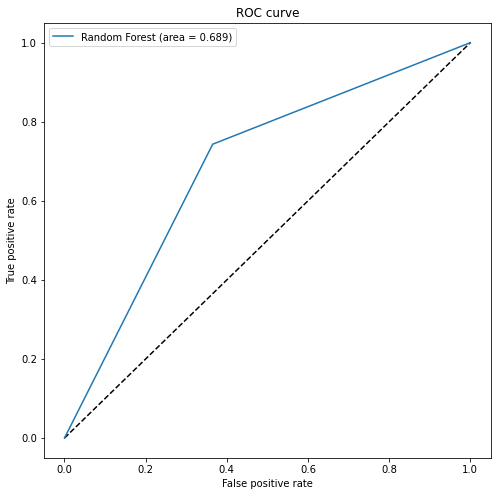

In [70]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred = clf.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random Forest (area = {:.3f})'.format(auc))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

The confusion matrix can also be drawn to see true positive, true negative, false positive and false negative.

True Negative  :  5131
False Positive :  2952
False Negative :  1776
True Positive  :  5141


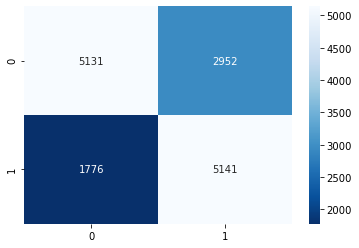

In [71]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True,cmap="Blues_r", fmt='g')
print ("True Negative  : ",tn)
print ("False Positive : ",fp)
print ("False Negative : ",fn)
print ("True Positive  : ",tp)

Next we can draw weighted matrix for cost errors as described in the document. We can do that easily.

In [72]:
#adding predictions to original test set
df1  = pd.DataFrame(X_test1,columns=x.columns)
df1['original'] = y_test
df1['preds'] = y_pred
df1

,item_id,brand_id,item_price,user_title,Age,Delivery_time,Weekday,Month,user_Age,item_size_fixed,original,preds
0,269.0,42.0,69.90,3.0,65.0,4.0,1.0,8.0,1718.0,29.0,0,1
1,2019.0,48.0,89.95,2.0,40.0,2.0,5.0,12.0,1714.0,140.0,0,0
2,211.0,1.0,59.90,3.0,55.0,2.0,2.0,8.0,1722.0,41.0,1,0
3,255.0,37.0,17.90,3.0,68.0,4.0,1.0,8.0,1771.0,10.0,0,0
4,1722.0,41.0,119.90,3.0,61.0,2.0,6.0,8.0,1694.0,38.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,871.0,38.0,69.90,1.0,49.0,11.0,2.0,8.0,2223.0,38.0,1,1
14996,144.0,14.0,24.90,3.0,57.0,1.0,2.0,8.0,1877.0,38.0,0,1
14997,1592.0,3.0,49.90,3.0,67.0,3.0,6.0,9.0,2149.0,38.0,1,1
14998,1653.0,42.0,159.90,3.0,50.0,2.0,1.0,9.0,1688.0,42.0,1,1


In [73]:
#calculating cost
def cost(x):
    if x['original']==x['preds']:
        return 0
    elif x['original']==1 and x['preds']==0:
        return (0.5*5)* (-(3+(0.1 * x['item_price'])))
    elif x['original']==0 and x['preds']==1:
        return (0.5 * x['item_price'])

#calculation confusion matrix
def confusion(x):
    if x['original']==1 and  x['preds']==1:
        return 'True Positive'
    if x['original']==0 and  x['preds']==0:
        return 'True Negative'
    elif x['original']==1 and x['preds']==0:
        return 'False Negative'
    elif x['original']==0 and x['preds']==1:
        return 'False Positive'
    
df1['confusion']=df1.apply(confusion, axis=1)
df1['cost_matrix']=df1.apply(cost, axis=1)


In [74]:
df1.head()

,item_id,brand_id,item_price,user_title,Age,Delivery_time,Weekday,Month,user_Age,item_size_fixed,original,preds,confusion,cost_matrix
0,269.0,42.0,69.90,3.0,65.0,4.0,1.0,8.0,1718.0,29.0,0,1,False Positive,34.950
1,2019.0,48.0,89.95,2.0,40.0,2.0,5.0,12.0,1714.0,140.0,0,0,True Negative,0.000
2,211.0,1.0,59.90,3.0,55.0,2.0,2.0,8.0,1722.0,41.0,1,0,False Negative,-22.475
3,255.0,37.0,17.90,3.0,68.0,4.0,1.0,8.0,1771.0,10.0,0,0,True Negative,0.000
4,1722.0,41.0,119.90,3.0,61.0,2.0,6.0,8.0,1694.0,38.0,0,0,True Negative,0.000


Now we can see the cost_matrix column in the dataframe and see cost along with their predicted confusion class to see the cost matrix. Next we have to perform the model on test set and save results in a csv.

<a id='test'></a>

## Test Phase

In this section we will make predictions on test data and save it in csv in required format.

#### Data Formatting
In this phase we have to modify data first to make it same as training data, for that we have to convert dates into features like age, delivery time like before. Also we have to remove nulls and drop reduncdant columns and then normalize features for testing. I will do all that in 1 step as its what we have done before. Also since we don't have return column in test set so we will be imputing for whole set and not for each class

In [77]:
#reading test dataset
df_test=pd.read_csv("test_set.csv")


#function to convert date to speicif format
def __datetime(date_str):
    
    #for null values set dob as current date to identify them as their age will be 0
    if date_str!=date_str:
        date_str=str(date.today())

    return datetime.strptime(date_str, '%Y-%m-%d')

#subtracting dob with current date and converting to years.
df_test['Age']=(__datetime(str(date.today()))-df_test.user_dob.apply(__datetime))/365
df_test['Age']=df_test.Age.apply(lambda x: int(str(x).split(" ")[0]) )

#function to impute 0 values
def imputing_age(i,y):
    i[y] =i[y].map( lambda x : i[y].median() if x == 0 else x) 
    return i

#Imputing 0 values with median for each class
df_test=imputing_age(df_test,'Age')

df_test.drop(['user_dob'], axis=1,inplace=True)


#function to convert date to specific format and to handle null dates
def datetime_delivery(date_str):
    #if date is null set it to 1900-01-01 to identify it and so that difference will be less than 0
    if date_str!=date_str:
        date_str='1900-01-01'

    return datetime.strptime(date_str, '%Y-%m-%d')

def weekday(x):
    #setting null date value to noday for weekday
    if x!=x:
        x='NoDay'
    else:
        x=datetime.strptime(x, '%Y-%m-%d').strftime('%A')
    return x
def month(x):
    #setting null date value to nomonth for month
    if x!=x:
        x='NoMonth'
    else:
        x=datetime.strptime(x, '%Y-%m-%d').strftime('%B')
    return x


#finding differece of order and delivery date
df_test['Delivery_time']=(df_test.delivery_date.apply(datetime_delivery)-df_test.order_date.apply(datetime_delivery))
df_test['Delivery_time']=df_test.Delivery_time.apply(lambda x: int(str(x).split(" ")[0]) )
#finding weekday
df_test['Weekday']=df_test.delivery_date.apply(weekday)
#finding month
df_test['Month']=df_test.delivery_date.apply(month)


def imputing_delivery(i,y):
    i[y] =i[y].map( lambda x : i[y].median() if x <= 0 else x)
    return i

#Imputing 0 values with median for each class
df_test=imputing_delivery(df_test,'Delivery_time')


#replacing NoDay with Sunday in weekday column
df_test['Weekday']=df_test['Weekday'].apply(lambda x: x if x!='NoDay' else 'Sunday')


#replacing NoMonth with August in month column
df_test['Month']=df_test['Month'].apply(lambda x: x if x!='NoMonth' else 'August')


#converting to suitable date format
def __datetime_reg(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

#subtracting registration date by current date to find days with retailer
df_test['user_Age']=(__datetime_reg(str(date.today()))-df_test.user_reg_date.apply(__datetime_reg))
df_test['user_Age']=df_test.user_Age.apply(lambda x: int(str(x).split(" ")[0]) )

df_test.drop(['order_date','delivery_date','user_reg_date'], axis=1,inplace=True)


df_test['user_title'] = le.transform(df_test.user_title.values)


def month_encode(x):
    return strptime(x,'%B').tm_mon

df_test['Month']=df_test.Month.apply(month_encode)

def weekday_encode(x):
    return strptime(x,'%A').tm_wday

df_test['Weekday']=df_test.Weekday.apply(weekday_encode)

def item_map_category(x):
    x=x.replace("+","")
    if x.isnumeric()==False:  
        if x=='xxxl':
            x=48
        elif x=='xxl':
            x=42
        elif x=='xl':
            x=40
        elif x=='l':
            x=38
        elif x=='m':
            x=29
        elif x=='s':
            x=10
        elif x=='xs':
            x=6
        else: #for non-reported size we choosing mid value
            x=40
    return int(x)
df_test['item_size_fixed']=df_test.item_size.apply(item_map_category)

#Final DF to attach predicitons to
Final_DF = df_test.loc[:, ['order_item_id']] # target variable

df_test.drop(['item_color','user_state','item_size','order_item_id','user_id'], axis=1,inplace=True)

#converting to numpy array
df_test_normalized= np.array(df_test)
df_test_normalized = sc.transform (df_test_normalized)


#Prediciton
Final_Prediction = clf.predict(df_test_normalized) #use the DT model to predict on the validation data

Final_DF['Predictions']=Final_Prediction

Final_DF.head()

,order_item_id,Predictions
0,100001,1
1,100002,1
2,100003,1
3,100004,0
4,100005,0


#### Saving Results
Now our results are ready, we can save them to a text file in csv format as described in the document.

In [78]:
Final_DF.to_csv("Results.txt",index=False)